In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import logging

In [8]:
# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler("rossmann_sales_forecasting.log"),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger()

In [9]:
# Set global visualization style
sns.set(style="whitegrid", palette="muted")

In [10]:
# Load datasets
try:
    train = pd.read_csv("../data/train.csv")
    test = pd.read_csv("../data/test.csv")
    store = pd.read_csv("../data/store.csv")
    logger.info("Datasets successfully loaded.")
except Exception as e:
    logger.error(f"Error loading datasets: {e}")
    raise

/tmp/ipykernel_34104/539559645.py:3: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv("../data/train.csv")
2025-01-05 16:32:24,450 - INFO - Datasets successfully loaded.


In [11]:
# Initial inspection
logger.info(f"Train data preview:\n{train.head()}")
logger.info(f"Test data preview:\n{test.head()}")
logger.info(f"Store data preview:\n{store.head()}")

2025-01-05 16:32:49,146 - INFO - Train data preview:
   Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5  2015-07-31   5263        555     1      1            0   
1      2          5  2015-07-31   6064        625     1      1            0   
2      3          5  2015-07-31   8314        821     1      1            0   
3      4          5  2015-07-31  13995       1498     1      1            0   
4      5          5  2015-07-31   4822        559     1      1            0   

   SchoolHoliday  
0              1  
1              1  
2              1  
3              1  
4              1  
2025-01-05 16:32:49,150 - INFO - Test data preview:
   Id  Store  DayOfWeek        Date  Open  Promo StateHoliday  SchoolHoliday
0   1      1          4  2015-09-17   1.0      1            0              0
1   2      3          4  2015-09-17   1.0      1            0              0
2   3      7          4  2015-09-17   1.0      1            0              

In [12]:
# Check for missing values
logger.info(f"Missing values in train dataset:\n{train.isnull().sum()}")
logger.info(f"Missing values in test dataset:\n{test.isnull().sum()}")
logger.info(f"Missing values in store dataset:\n{store.isnull().sum()}")

2025-01-05 16:35:52,257 - INFO - Missing values in train dataset:
Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64
2025-01-05 16:35:52,261 - INFO - Missing values in test dataset:
Id                0
Store             0
DayOfWeek         0
Date              0
Open             11
Promo             0
StateHoliday      0
SchoolHoliday     0
dtype: int64
2025-01-05 16:35:52,262 - INFO - Missing values in store dataset:
Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64


In [13]:
# Check data types
logger.info(f"Data types in train dataset:\n{train.dtypes}")
logger.info(f"Data types in test dataset:\n{test.dtypes}")
logger.info(f"Data types in store dataset:\n{store.dtypes}")

2025-01-05 16:36:36,944 - INFO - Data types in train dataset:
Store             int64
DayOfWeek         int64
Date             object
Sales             int64
Customers         int64
Open              int64
Promo             int64
StateHoliday     object
SchoolHoliday     int64
dtype: object
2025-01-05 16:36:36,946 - INFO - Data types in test dataset:
Id                 int64
Store              int64
DayOfWeek          int64
Date              object
Open             float64
Promo              int64
StateHoliday      object
SchoolHoliday      int64
dtype: object
2025-01-05 16:36:36,948 - INFO - Data types in store dataset:
Store                          int64
StoreType                     object
Assortment                    object
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                 object
d

In [14]:
# Handle missing values
test['Open'].fillna(test['Open'].mode()[0], inplace=True)
store['CompetitionDistance'].fillna(store['CompetitionDistance'].median(), inplace=True)
store['CompetitionOpenSinceMonth'].fillna(0, inplace=True)
store['CompetitionOpenSinceYear'].fillna(0, inplace=True)
store['Promo2SinceWeek'].fillna(0, inplace=True)
store['Promo2SinceYear'].fillna(0, inplace=True)
store['PromoInterval'].fillna("None", inplace=True)
logger.info("Missing values in store dataset handled.")

/tmp/ipykernel_34104/708664855.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test['Open'].fillna(test['Open'].mode(), inplace=True)
/tmp/ipykernel_34104/708664855.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)'

In [30]:
# Merge datasets
train = train.merge(store, on='Store', how='left')
test = test.merge(store, on='Store', how='left')
logger.info("Datasets merged successfully.")

2025-01-05 17:23:26,040 - INFO - Datasets merged successfully.


In [31]:
# Feature engineering
train['Year'] = pd.to_datetime(train['Date']).dt.year
train['Month'] = pd.to_datetime(train['Date']).dt.month
train['WeekOfYear'] = pd.to_datetime(train['Date']).dt.isocalendar().week
train['DayOfMonth'] = pd.to_datetime(train['Date']).dt.day

test['Year'] = pd.to_datetime(test['Date']).dt.year
test['Month'] = pd.to_datetime(test['Date']).dt.month
test['WeekOfYear'] = pd.to_datetime(test['Date']).dt.isocalendar().week
test['DayOfMonth'] = pd.to_datetime(test['Date']).dt.day
logger.info("Feature engineering completed.")

2025-01-05 17:24:54,132 - INFO - Feature engineering completed.


2025-01-05 18:00:33,532 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-01-05 18:00:34,007 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


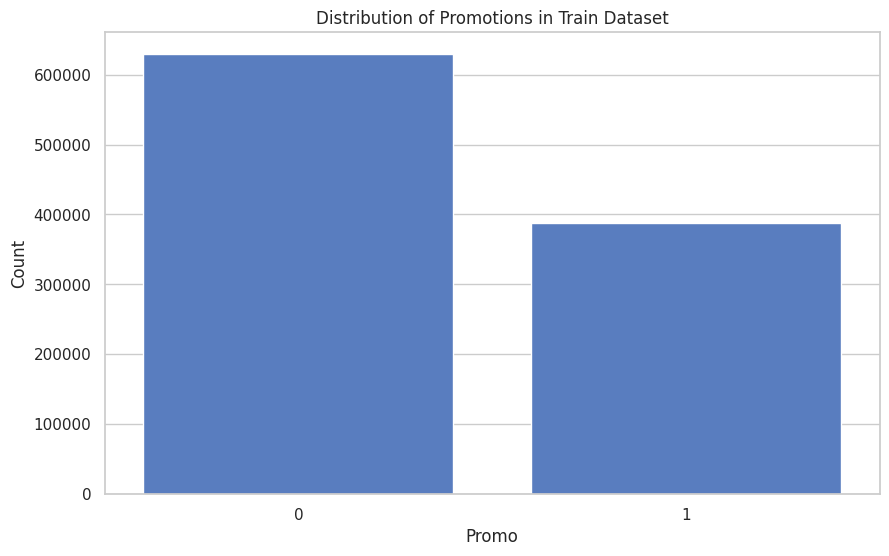

2025-01-05 18:00:34,274 - INFO - Total count of Promo=1: 388080.00
2025-01-05 18:00:34,275 - INFO - Total count of Promo=0: 629129.00


In [38]:
# Check Promo distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=train, x='Promo')
plt.title('Distribution of Promotions in Train Dataset')
plt.xlabel('Promo')
plt.ylabel('Count')
plt.show()

promo = train.groupby('Promo')['Promo'].count()
logger.info(f"Total count of Promo=1: {promo[1]:.2f}")
logger.info(f"Total count of Promo=0: {promo[0]:.2f}")

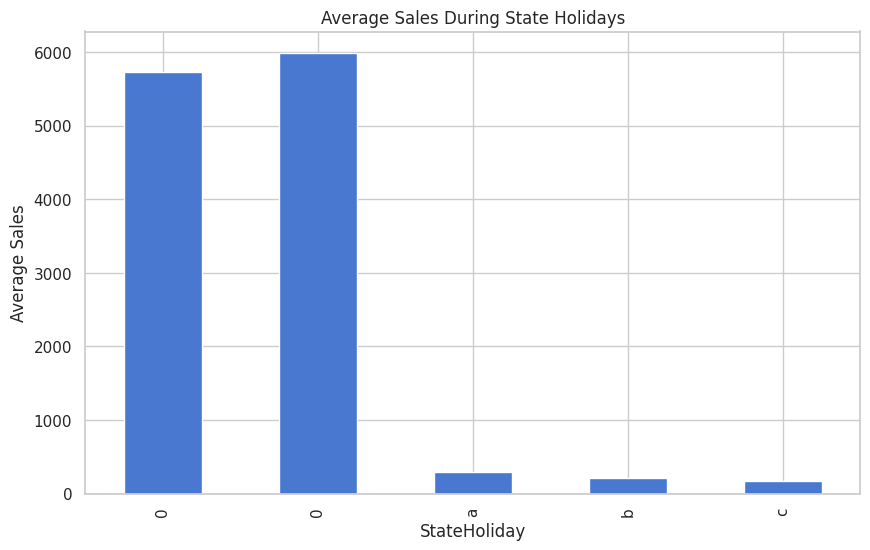

In [39]:
# Average sales during holidays
holiday_sales = train.groupby('StateHoliday')['Sales'].mean()
plt.figure(figsize=(10, 6))
holiday_sales.plot(kind='bar')
plt.title('Average Sales During State Holidays')
plt.xlabel('StateHoliday')
plt.ylabel('Average Sales')
plt.show()

In [47]:
train['StateHoliday'] = train['StateHoliday'].astype(str).str.strip()


In [ ]:
state_holiday_sales = train.groupby('StateHoliday')['Sales'].mean()
print(state_holiday_sales)

StateHoliday
0    5947.483893
a     290.735686
b     214.311510
c     168.733171
Name: Sales, dtype: float64


In [49]:
print(train['StateHoliday'].unique())

['0' 'a' 'b' 'c']


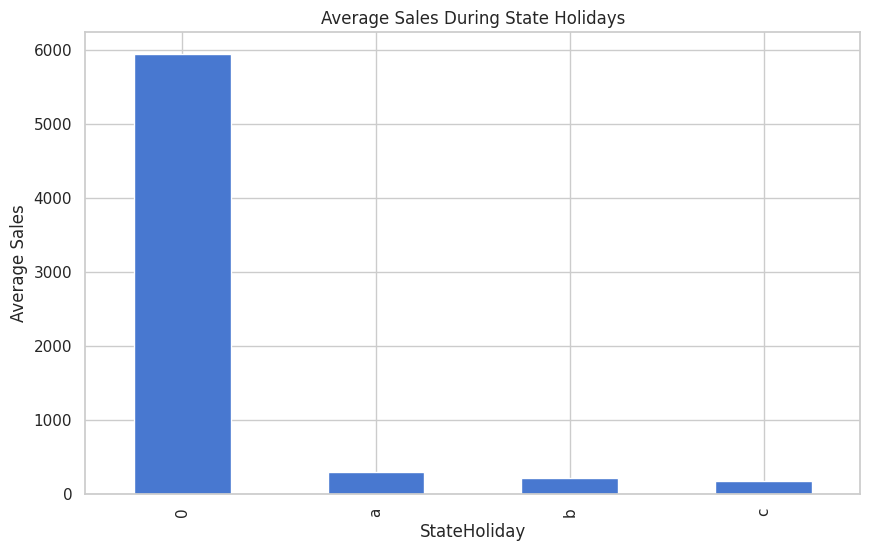

In [50]:
# Average sales during holidays
holiday_sales = train.groupby('StateHoliday')['Sales'].mean()
plt.figure(figsize=(10, 6))
holiday_sales.plot(kind='bar')
plt.title('Average Sales During State Holidays')
plt.xlabel('StateHoliday')
plt.ylabel('Average Sales')
plt.show()

In [52]:
logger.info(f"Average sales on StateHoliday=0: {holiday_sales[0]:.2f}")
logger.info(f"Average sales on StateHoliday=a: {holiday_sales[1]:.2f}")
logger.info(f"Average sales on StateHoliday=b: {holiday_sales[2]:.2f}")
logger.info(f"Average sales on StateHoliday=c: {holiday_sales[3]:.2f}")

/tmp/ipykernel_34104/3999195035.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  logger.info(f"Average sales on StateHoliday=0: {holiday_sales[0]:.2f}")
2025-01-05 18:36:51,347 - INFO - Average sales on StateHoliday=0: 5947.48
/tmp/ipykernel_34104/3999195035.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  logger.info(f"Average sales on StateHoliday=a: {holiday_sales[1]:.2f}")
2025-01-05 18:36:51,349 - INFO - Average sales on StateHoliday=a: 290.74
/tmp/ipykernel_34104/3999195035.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be tr

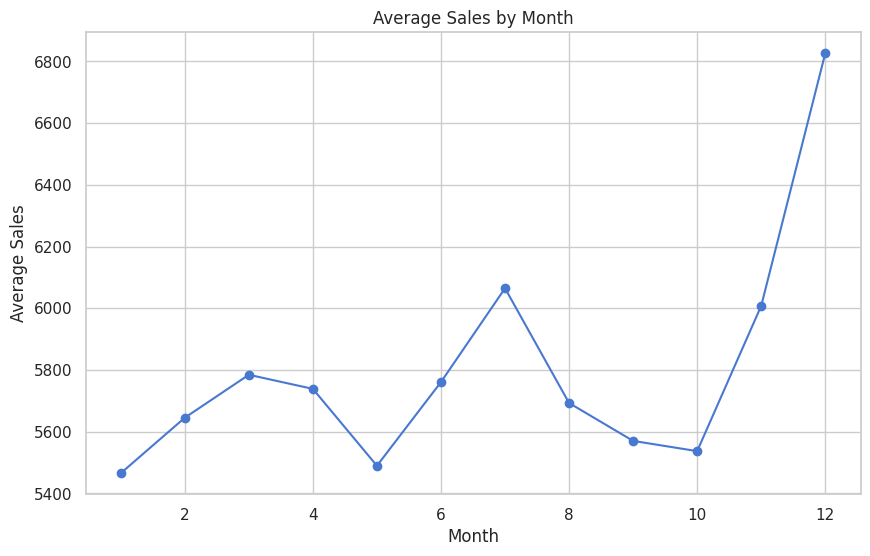

In [53]:
# Time-series analysis
train['Date'] = pd.to_datetime(train['Date'])
seasonal_sales = train.groupby(train['Date'].dt.month)['Sales'].mean()

plt.figure(figsize=(10, 6))
seasonal_sales.plot(kind='line', marker='o')
plt.title('Average Sales by Month')
plt.xlabel('Month')
plt.ylabel('Average Sales')
plt.show()

In [59]:
logger.info(f"Average Sales by Month:\n{seasonal_sales}")

2025-01-05 18:45:16,372 - INFO - Average Sales by Month:
Date
1     5465.395529
2     5645.253150
3     5784.578871
4     5738.866916
5     5489.639973
6     5760.964375
7     6064.915711
8     5693.016554
9     5570.246033
10    5537.037419
11    6008.111821
12    6826.611377
Name: Sales, dtype: float64


2025-01-05 18:47:36,781 - INFO - Correlation between Sales and Customers: 0.8947107733017032


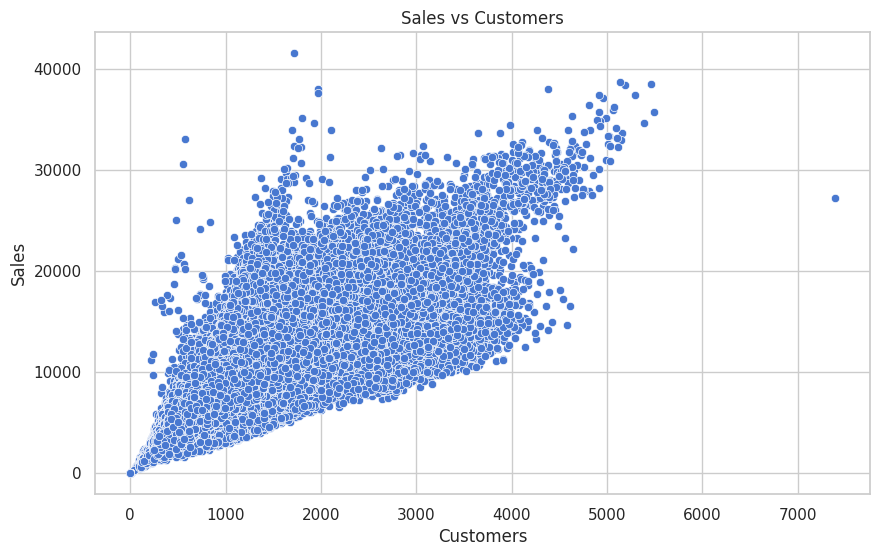

In [60]:
# Correlation and scatter plot
correlation = train['Sales'].corr(train['Customers'])
logger.info(f"Correlation between Sales and Customers: {correlation}")

plt.figure(figsize=(10, 6))
sns.scatterplot(data=train, x='Customers', y='Sales')
plt.title('Sales vs Customers')
plt.xlabel('Customers')
plt.ylabel('Sales')
plt.show()

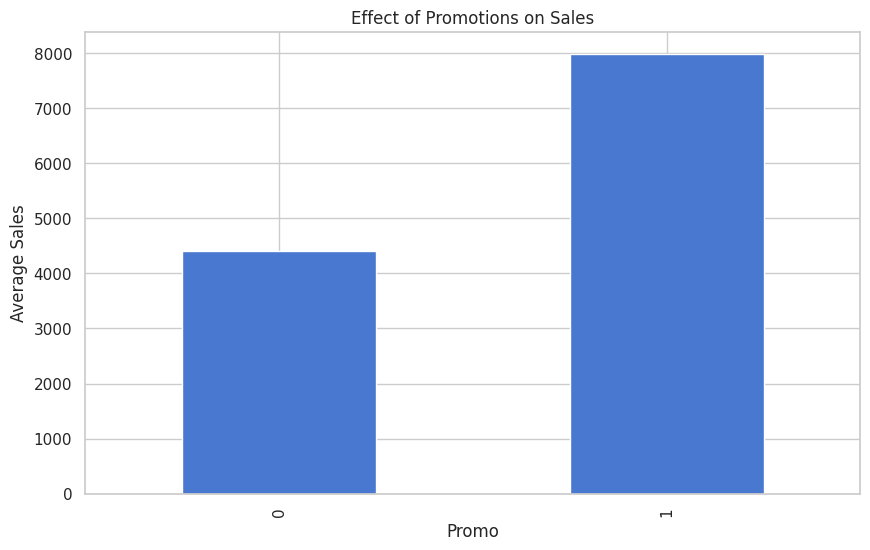

In [61]:
# Promo vs Sales
promo_sales = train.groupby('Promo')['Sales'].mean()
plt.figure(figsize=(10, 6))
promo_sales.plot(kind='bar')
plt.title('Effect of Promotions on Sales')
plt.xlabel('Promo')
plt.ylabel('Average Sales')
plt.show()

In [62]:
logger.info(f"Effect of Promotions on Sales:\n{promo_sales}")

2025-01-05 18:50:17,046 - INFO - Effect of Promotions on Sales:
Promo
0    4406.050805
1    7991.152046
Name: Sales, dtype: float64


In [63]:
train.to_csv("cleaned_train.csv", index=False)
test.to_csv("cleaned_test.csv", index=False)
logger.info("Cleaned datasets saved for future analysis.")

2025-01-05 18:51:57,046 - INFO - Cleaned datasets saved for future analysis.
